Title: 4. Title Generation - Developing the Model
Tags: improving_results
Authors: Ben Hoyle
Summary: This post looks at developing our initial models to include state of the art features to improve results.

# 4. Title Generation - Developing the Model

This post looks at developing our initial models to include state of the art features to improve results.

To recap:

* We have two models: the Ludwig model and the Chollet/Brownlee model. 
* Performance so far has been fairly poor.
* Each model had slightly different characteristics - the Ludwig model produced better formed output but seemed to simply memorise and repeat titles, the Chollet/Brownlee model had a lower loss and appeared to memorise less but produced more nonsensical outputs.

In our last post we identified a number of ways to improve our models:

1. Use GloVe encodings and a shared embedding layer. 
2. Add attention.
3. Add pointers / skip connections between our input and our output.
4. Use a coverage measure.
5. Use different word forms such as lemmas or stems.
6. Use a GAN-style discriminator on the output.
7. Improve our sampling by employing beam search.

We will look at some of these in this post.

In [4]:
# Imports 
import numpy as np
import os

## Pre-trained Shared Embeddings 

First download the glove embeddings text file from [here](http://nlp.stanford.edu/data/glove.6B.zip). This is to be placed in a `/glove` directory.

Then we follow the steps from Ludwig's example to generate our embedding matrix. 

In [12]:
GLOVE_DIR = "glove/"

embeddings_index = {}
# For Python 3 tweaked to add 'rb'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    # Tweaked to decode the binary text values
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
len(embeddings_index)

400000

In [14]:
list(embeddings_index.keys())[0:10]

['irati',
 'fotiou',
 '8-year',
 'usagi',
 'autobianchi',
 'eldercare',
 'puraskar',
 'dench',
 'ventrally',
 'amsc']

In [16]:
embeddings_index.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

---
#### Load and Tokenize Data

Initially we load our data as before. As we are using shared embeddings we will train a common tokenizer on both the claim text and title.

In [17]:
# Set parameters
num_decoder_tokens = 2500 # This is our output title vocabulary
num_encoder_tokens = 2500 # This is our input claim vocabulary
encoder_seq_length = 300 # This is our limit for our input claim length
decoder_seq_length = 22 # This is our limit for our output title length - 20 + 2 for start/stop

In [18]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
    
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]
                                      
print("\n\nAn example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded


Adding start and stop tokens to output


An example title: startseq System and method for session restoration at geo-redundant gateways stopseq
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reat

In [19]:
from keras.preprocessing import text
t_joint = text.Tokenizer(
                num_words=num_encoder_tokens, 
                lower=True,
                char_level=False,
                oov_token="<UNK>"
)
X_texts = [d[0] for d in data]
Y_texts = [d[1] for d in data]
total_texts = X_texts + Y_texts
t_joint.fit_on_texts(total_texts)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
list(t_joint.word_index.keys())[0:10]

['remapper',
 'inactive',
 'imposes',
 'overestimates',
 'roman',
 'mitigating',
 "location's",
 '56a',
 'buckle',
 'billable']

In [23]:
X_seqs = t_joint.texts_to_sequences(X_texts)
Y_seqs = t_joint.texts_to_sequences(Y_texts)
print("Our input sequences (claims) have a max integer value of {0}".format(max([max(x) for x in X_seqs])))
print("Our output sequences (titles) have a max integer value of {0}".format(max([max(y) for y in Y_seqs])))

Our input sequences (claims) have a max integer value of 2499
Our output sequences (titles) have a vocabulary of 2499 words


In [34]:
vocab_size = max([max(x + y) for x, y in zip(X_seqs, Y_seqs)]) + 1
vocab_size

2500

In [25]:
filtered_seqs = [(x, y) for x,y in zip(X_seqs, Y_seqs) if len(x) <= encoder_seq_length and len(y) <= decoder_seq_length]
X_seqs = [x for x, _ in filtered_seqs]
Y_seqs = [y for _, y in filtered_seqs]

X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest input sequence is {0} tokens long.".format(max_length))

Y_length = [len(y) for y in Y_seqs]
max_length = max(Y_length)
print("Our longest output sequence is {0} tokens long.".format(max_length))

Our longest input sequence is 300 tokens long.
Our longest output sequence is 22 tokens long.


In [39]:
word_embedding_size = 100 # As we are using the Glove 100d data
print('Found {0} word vectors.'.format(len(embeddings_index)))
embedding_matrix = np.zeros((vocab_size, word_embedding_size))

# Filter our vocab to only the used items
words = [(w, i) for w, i in t_joint.word_index.items() if int(i) < vocab_size]

# This is from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/      
for word, i in words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [40]:
embedding_matrix.shape

(2500, 100)

Aside: can I use the embedding matrix as the weights for a dense layer that is multiplied by the probabilities of the decoder output?

In [41]:
print(X_texts[0], X_seqs[0])
print(Y_texts[0], Y_seqs[0])


1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reattach to the network, wherein each DDN causes the MME to send a detach request with a reattach request code to the respective UE.

 [31, 2, 29, 8, 448, 2, 552, 91, 1047, 42, 19, 2, 397, 1, 29, 26, 1959, 5

In [42]:
# Pad the data
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X_seqs, maxlen=encoder_seq_length)
Y = pad_sequences(Y_seqs, maxlen=decoder_seq_length, padding='post')

print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (25632, 300) and our Y data has shape (25632, 22)


In [49]:
Y[0]

array([  34,   30,    5,   29,    8,  352,   14, 1836,   35,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

### Ludwig Model

There are actually two models described by Oswaldo. A first introductory model and a second model that uses an additional adversarial network. The first model is easier to understand so we will start with that.

In [68]:
# imports
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline
from keras.layers import concatenate

y_vocab_len = num_decoder_tokens # This is our output title vocabulary
X_vocab_len = num_encoder_tokens # This is our input claim vocabulary
X_max_len = encoder_seq_length # This is our limit for our input claim length
y_max_len = decoder_seq_length # This is our limit for our output title length - 20 + 2 for start/stop

# source text input model
inputs1 = Input(shape=(X_max_len,))
#am1 = Embedding(X_vocab_len, 128)(inputs1)
Shared_Embedding = Embedding(
    output_dim=word_embedding_size, 
    input_dim=vocab_size, 
    weights=[embedding_matrix], 
    input_length=X_vocab_len
)
am1 = Shared_Embedding(inputs1)
am2 = LSTM(128)(am1)
# summary input model
inputs2 = Input(shape=(y_max_len,))
sm1 = Shared_Embedding(inputs2)
sm2 = LSTM(128)(sm1)
# decoder output model
decoder1 = concatenate([am2, sm2])
outputs = Dense(y_vocab_len, activation='softmax')(decoder1)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [69]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2500, 100)    250000      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 128)          117248      embedding_3[0][0]                
__________

Now we see that the embedding is shared by both LSTMs.

In [70]:
# We need to split into train and test data
from sklearn.model_selection import train_test_split

# seed for reproducing same results
seed = 9
np.random.seed(seed)

# split the data into training (80%) and testing (20%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [71]:
Y[0]

array([  34,   30,    5,   29,    8,  352,   14, 1836,   35,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [77]:
def generate_set(X, Y, i_end, i):
    """ Generate the data for training/validation from X and Y.
    i_end is the end of the set, i is the start."""
    set_size = 0
    limit_list = list()
    for sent in Y[i:i_end]:
        # Edited below to use integer value of EOS symbol
        limit = np.where(sent==t_joint.word_index["stopseq"])[0][0]  #  the position of the symbol EOS
        set_size += limit + 1
        limit_list.append(limit)
   
    # We need to change this bit to set our array size based on the limit values
    # Generate blank arrays for the set
    I_1 = np.zeros((set_size, X_max_len))
    I_2 = np.zeros((set_size, y_max_len))
    # This below is a big array
    Y_set = np.zeros((set_size, y_vocab_len))
    count = 0
    # Now we want to create, for each sample, a set of examples for each word in the title
    # Have we just been training on 0 to 100?!?!
    for l in range(0, (i_end - i)):
        # for each X and y in set of NB_SET 
            
        # We need to build the input for the second encoder for the next word in y
        # I.e. for word 3 in the title the input2 consists of words 1 and 2 (using teacher forcing)
            
        # Get length of current title - i.e. where the integer = 2 = stopseq
        limit = limit_list[l]
            
        # We only need to create examples up to the length of the title 
        for m in range(1, limit+1):
                
            # Generate our one-hot y out
            one_hot_out = np.zeros((1, y_vocab_len))
            # This builds our one-hot generation into our training loop
            # The l and m respectively iterate through the samples and the output sequence elements
            one_hot_out[0, Y[l+i][m]] = 1
                
            # Create a blank row/array for a partial input for our summary model - this is fed into the decoder
            # It is of the same size as our title
            partial_input = np.zeros((1, y_max_len))
            # Don't we also need to set partial input [0] to startseq as well? - no that's taken care of
            # by m starting at one but our range below starting at 0
            
            # Because we are zero padding add words up to m to end - DOES THIS STILL WORK IF WE ZERO PAD
            # AT THE END? - Yes but we just feed the words with zeros first?
            # What happens if we change this to 0:m?! - if we have [1, 2, 3, 4] this will generate
            # [0,0,0,1], [0,0,1,2], [0,1, 2, 3]
            # Our zero padding is at the end though so our seqs looks like [1,2,3,0,0,0], 
            # But I know you want the data need the end of the input seq to prevent forgetting
            partial_input[0, -m:] = Y[l+i][0:m]
            
            # This fills in each sample of the training data, i.e. count increments up to set size
            I_1[count, :] = X[l+i]
            I_2[count, :] = partial_input
            Y_set[count, :] = one_hot_out
            count += 1
                
        # Shuffle the I_1, I_2 and Y_set vectors for better training - trick from RL
        # - see here - np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X);
        indices = np.random.permutation(I_1.shape[0])
        np.take(I_1, indices, axis=0, out=I_1)
        np.take(I_2, indices, axis=0, out=I_2)
        np.take(Y_set, indices, axis=0, out=Y_set)
    return I_1, I_2, Y_set

In [78]:
# Basing training in sets code on here - https://github.com/ChunML/seq2seq/blob/master/seq2seq.py

# Function to look for saved weights file
def find_checkpoint_file(folder):
    checkpoint_file = [f for f in os.listdir(folder) if 'v2_kerascheckpoint' in f]
    if len(checkpoint_file) == 0:
        return []
    modified_time = [os.path.getmtime(f) for f in checkpoint_file]
    return checkpoint_file[np.argmax(modified_time)]

# Finding trained weights of previous epoch if any
saved_weights = find_checkpoint_file('.')

k_start = 1

# If any trained weight was found, then load them into the model
if len(saved_weights) != 0:
    print('[INFO] Saved weights found, loading...')
    epoch = saved_weights[saved_weights.rfind('_')+1:saved_weights.rfind('.')]
    model.load_weights(saved_weights)
    k_start = int(epoch) + 1

# So instead of X we have [inputs1, inputs2] - this is where we need to fold in 
# - https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/blob/master/train_bot.py

# So we have inputs2 that build up - we have a set of inputs2 up to the length of inputs2

# We need to refactor some of the loops below as functions - we can then apply to test data to generate a validation set

[INFO] Saved weights found, loading...


Uh oh - a problem with using embeddings is that our start and stop tokens are no longer 1 and 2!

*** Fixed above ***

In [74]:
# For now we can just change 2 to the variable below - in future it is probably better to build our our tokenizer that
# reserves control characters
t_joint.word_index["stopseq"]

35

In [82]:
import math

BATCH_SIZE = 32 # Depends on GPU - most values are around this 32-128 
NB_EPOCH = 20
# Number of examples to group together in a set - 100 is fast / 1000 is too much on an 8-core i7 laptop
# I think 100 is good - 250 takes a time to generate the sets of test data
NB_SET = 250

In [75]:
i_end = 0
num_examples = len(X_train)
num_test = len(X_test)
# Initialise history of accuracy
train_loss = list()
val_loss = list()

In [83]:
# Continue from loaded epoch number or new epoch if not loaded
for k in range(k_start, NB_EPOCH+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    X_train = X_train[indices]
    Y_train = Y_train[indices]
    indices = np.arange(num_test)
    np.random.shuffle(indices)
    X_test = X_test[indices]
    Y_test = Y_test[indices]

    # This for loop rotates through NB_SET samples at a time to avoid memory issues
    # E.g. Training 100 sequences at a time
    for i in range(0, num_examples, NB_SET):
        if i + NB_SET >= num_examples:
            i_end = num_examples
        else:
            i_end = i + NB_SET
        
        # Generate a range for the test data
        i_test = math.floor(i * (num_test/num_examples))
        i_test_end = math.floor(i_end * (num_test/num_examples))
            
        I_1_train, I_2_train, Y_set_train = generate_set(X_train, Y_train, i_end, i)
        I_1_test, I_2_test, Y_set_test = generate_set(X_test, Y_test, i_test_end, i_test)
              
        print('[INFO] Training model: epoch {} - {}/{} samples'.format(k, i, num_examples))
        callback = model.fit(
            [I_1_train, I_2_train], 
            Y_set_train, 
            validation_data=([I_1_test, I_2_test], Y_set_test),
            batch_size=BATCH_SIZE, 
            epochs=1
        )
        train_loss += callback.history['loss']
        val_loss += callback.history['val_loss']
        # Get history and apppend new data to running set here
    model.save_weights('v2_kerascheckpoint_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 2 - 0/20505 samples
Train on 2534 samples, validate on 603 samples
Epoch 1/1
2534/2534 [==============================] - 22s 9ms/step - loss: 2.2101 - val_loss: 2.3826
[INFO] Training model: epoch 2 - 250/20505 samples
Train on 2464 samples, validate on 677 samples
Epoch 1/1
2464/2464 [==============================] - 22s 9ms/step - loss: 2.1098 - val_loss: 2.2632
[INFO] Training model: epoch 2 - 500/20505 samples
Train on 2404 samples, validate on 630 samples
Epoch 1/1
2404/2404 [==============================] - 21s 9ms/step - loss: 2.1046 - val_loss: 2.4288
[INFO] Training model: epoch 2 - 750/20505 samples
Train on 2516 samples, validate on 646 samples
Epoch 1/1
2516/2516 [==============================] - 22s 9ms/step - loss: 2.1949 - val_loss: 2.6369
[INFO] Training model: epoch 2 - 1000/20505 samples
Train on 2510 samples, validate on 607 samples
Epoch 1/1
2510/2510 [==============================] - 22s 9ms/step - loss: 2.2015 - val_loss: 2.3367
[

2390/2390 [==============================] - 22s 9ms/step - loss: 2.2061 - val_loss: 2.6325
[INFO] Training model: epoch 2 - 10250/20505 samples
Train on 2453 samples, validate on 702 samples
Epoch 1/1
2453/2453 [==============================] - 23s 10ms/step - loss: 2.0870 - val_loss: 2.3913
[INFO] Training model: epoch 2 - 10500/20505 samples
Train on 2484 samples, validate on 593 samples
Epoch 1/1
2484/2484 [==============================] - 23s 9ms/step - loss: 2.2218 - val_loss: 2.2163
[INFO] Training model: epoch 2 - 10750/20505 samples
Train on 2424 samples, validate on 630 samples
Epoch 1/1
2424/2424 [==============================] - 23s 9ms/step - loss: 2.1853 - val_loss: 2.4196
[INFO] Training model: epoch 2 - 11000/20505 samples
Train on 2435 samples, validate on 619 samples
Epoch 1/1
2435/2435 [==============================] - 23s 9ms/step - loss: 2.2041 - val_loss: 2.3025
[INFO] Training model: epoch 2 - 11250/20505 samples
Train on 2503 samples, validate on 649 samples

2478/2478 [==============================] - 23s 9ms/step - loss: 2.1018 - val_loss: 2.4592
[INFO] Training model: epoch 2 - 20500/20505 samples
Train on 36 samples, validate on 12 samples
Epoch 1/1
36/36 [==============================] - 1s 15ms/step - loss: 2.5730 - val_loss: 3.4734
[INFO] Training model: epoch 3 - 0/20505 samples
Train on 2446 samples, validate on 591 samples
Epoch 1/1
2446/2446 [==============================] - 21s 9ms/step - loss: 1.9679 - val_loss: 2.3590
[INFO] Training model: epoch 3 - 250/20505 samples
Train on 2541 samples, validate on 621 samples
Epoch 1/1
2541/2541 [==============================] - 24s 9ms/step - loss: 2.0008 - val_loss: 2.3540
[INFO] Training model: epoch 3 - 500/20505 samples
Train on 2429 samples, validate on 603 samples
Epoch 1/1
2429/2429 [==============================] - 22s 9ms/step - loss: 1.9819 - val_loss: 2.1722
[INFO] Training model: epoch 3 - 750/20505 samples
Train on 2416 samples, validate on 573 samples
Epoch 1/1
2416/24

2401/2401 [==============================] - 21s 9ms/step - loss: 2.0529 - val_loss: 2.2487
[INFO] Training model: epoch 3 - 10000/20505 samples
Train on 2424 samples, validate on 656 samples
Epoch 1/1
2424/2424 [==============================] - 23s 9ms/step - loss: 2.0596 - val_loss: 2.2842
[INFO] Training model: epoch 3 - 10250/20505 samples
Train on 2402 samples, validate on 619 samples
Epoch 1/1
2402/2402 [==============================] - 22s 9ms/step - loss: 2.0181 - val_loss: 2.2941
[INFO] Training model: epoch 3 - 10500/20505 samples
Train on 2485 samples, validate on 601 samples
Epoch 1/1
2485/2485 [==============================] - 21s 9ms/step - loss: 1.9160 - val_loss: 2.2243
[INFO] Training model: epoch 3 - 10750/20505 samples
Train on 2408 samples, validate on 661 samples
Epoch 1/1
2408/2408 [==============================] - 23s 10ms/step - loss: 2.0305 - val_loss: 2.3228
[INFO] Training model: epoch 3 - 11000/20505 samples
Train on 2464 samples, validate on 612 samples

2449/2449 [==============================] - 23s 9ms/step - loss: 2.0629 - val_loss: 2.1767
[INFO] Training model: epoch 3 - 20250/20505 samples
Train on 2452 samples, validate on 581 samples
Epoch 1/1
2452/2452 [==============================] - 23s 9ms/step - loss: 2.0039 - val_loss: 2.3421
[INFO] Training model: epoch 3 - 20500/20505 samples
Train on 29 samples, validate on 14 samples
Epoch 1/1
29/29 [==============================] - 0s 11ms/step - loss: 1.6708 - val_loss: 2.6099
[INFO] Training model: epoch 4 - 0/20505 samples
Train on 2575 samples, validate on 584 samples
Epoch 1/1
2575/2575 [==============================] - 22s 9ms/step - loss: 1.8181 - val_loss: 2.2501
[INFO] Training model: epoch 4 - 250/20505 samples
Train on 2533 samples, validate on 595 samples
Epoch 1/1
2533/2533 [==============================] - 24s 9ms/step - loss: 1.8656 - val_loss: 2.3783
[INFO] Training model: epoch 4 - 500/20505 samples
Train on 2433 samples, validate on 623 samples
Epoch 1/1
2433/

2618/2618 [==============================] - 24s 9ms/step - loss: 1.8837 - val_loss: 2.1510
[INFO] Training model: epoch 4 - 9750/20505 samples
Train on 2466 samples, validate on 628 samples
Epoch 1/1
2466/2466 [==============================] - 23s 9ms/step - loss: 1.8331 - val_loss: 2.1895
[INFO] Training model: epoch 4 - 10000/20505 samples
Train on 2588 samples, validate on 598 samples
Epoch 1/1
2588/2588 [==============================] - 24s 9ms/step - loss: 1.9080 - val_loss: 2.2784
[INFO] Training model: epoch 4 - 10250/20505 samples
Train on 2361 samples, validate on 679 samples
Epoch 1/1
2361/2361 [==============================] - 21s 9ms/step - loss: 1.9049 - val_loss: 2.2427
[INFO] Training model: epoch 4 - 10500/20505 samples
Train on 2474 samples, validate on 582 samples
Epoch 1/1
2474/2474 [==============================] - 23s 9ms/step - loss: 1.9174 - val_loss: 2.2741
[INFO] Training model: epoch 4 - 10750/20505 samples
Train on 2365 samples, validate on 654 samples
E

2472/2472 [==============================] - 23s 9ms/step - loss: 1.9326 - val_loss: 2.2581
[INFO] Training model: epoch 4 - 20000/20505 samples
Train on 2673 samples, validate on 612 samples
Epoch 1/1
2673/2673 [==============================] - 25s 9ms/step - loss: 1.8769 - val_loss: 2.1921
[INFO] Training model: epoch 4 - 20250/20505 samples
Train on 2570 samples, validate on 579 samples
Epoch 1/1
2570/2570 [==============================] - 24s 9ms/step - loss: 1.9859 - val_loss: 2.5148
[INFO] Training model: epoch 4 - 20500/20505 samples
Train on 48 samples, validate on 16 samples
Epoch 1/1
48/48 [==============================] - 1s 11ms/step - loss: 1.7381 - val_loss: 1.6902
[INFO] Training model: epoch 5 - 0/20505 samples
Train on 2449 samples, validate on 634 samples
Epoch 1/1
2449/2449 [==============================] - 23s 9ms/step - loss: 1.6588 - val_loss: 2.1795
[INFO] Training model: epoch 5 - 250/20505 samples
Train on 2528 samples, validate on 672 samples
Epoch 1/1
252

2531/2531 [==============================] - 23s 9ms/step - loss: 1.7499 - val_loss: 2.5523
[INFO] Training model: epoch 5 - 9500/20505 samples
Train on 2451 samples, validate on 602 samples
Epoch 1/1
2451/2451 [==============================] - 21s 9ms/step - loss: 1.7993 - val_loss: 2.5333
[INFO] Training model: epoch 5 - 9750/20505 samples
Train on 2461 samples, validate on 618 samples
Epoch 1/1
2461/2461 [==============================] - 23s 9ms/step - loss: 1.7712 - val_loss: 2.2353
[INFO] Training model: epoch 5 - 10000/20505 samples
Train on 2493 samples, validate on 640 samples
Epoch 1/1
2493/2493 [==============================] - 22s 9ms/step - loss: 1.8271 - val_loss: 2.3032
[INFO] Training model: epoch 5 - 10250/20505 samples
Train on 2477 samples, validate on 590 samples
Epoch 1/1
2477/2477 [==============================] - 23s 9ms/step - loss: 1.7321 - val_loss: 2.5237
[INFO] Training model: epoch 5 - 10500/20505 samples
Train on 2462 samples, validate on 587 samples
Ep

2447/2447 [==============================] - 23s 9ms/step - loss: 1.8832 - val_loss: 2.1714
[INFO] Training model: epoch 5 - 19750/20505 samples
Train on 2476 samples, validate on 646 samples
Epoch 1/1
2476/2476 [==============================] - 23s 9ms/step - loss: 1.7426 - val_loss: 2.5985
[INFO] Training model: epoch 5 - 20000/20505 samples
Train on 2446 samples, validate on 641 samples
Epoch 1/1
2446/2446 [==============================] - 21s 9ms/step - loss: 1.8426 - val_loss: 2.3097
[INFO] Training model: epoch 5 - 20250/20505 samples
Train on 2414 samples, validate on 673 samples
Epoch 1/1
2414/2414 [==============================] - 22s 9ms/step - loss: 1.7997 - val_loss: 2.2960
[INFO] Training model: epoch 5 - 20500/20505 samples
Train on 58 samples, validate on 16 samples
Epoch 1/1
58/58 [==============================] - 1s 11ms/step - loss: 1.6416 - val_loss: 3.4273
[INFO] Training model: epoch 6 - 0/20505 samples
Train on 2421 samples, validate on 627 samples
Epoch 1/1
2

2425/2425 [==============================] - 22s 9ms/step - loss: 1.6890 - val_loss: 2.2453
[INFO] Training model: epoch 6 - 9250/20505 samples
Train on 2443 samples, validate on 628 samples
Epoch 1/1
2443/2443 [==============================] - 21s 9ms/step - loss: 1.7445 - val_loss: 2.1644
[INFO] Training model: epoch 6 - 9500/20505 samples
Train on 2543 samples, validate on 639 samples
Epoch 1/1
2543/2543 [==============================] - 24s 9ms/step - loss: 1.7439 - val_loss: 2.5242
[INFO] Training model: epoch 6 - 9750/20505 samples
Train on 2472 samples, validate on 621 samples
Epoch 1/1
2472/2472 [==============================] - 23s 9ms/step - loss: 1.6768 - val_loss: 2.3641
[INFO] Training model: epoch 6 - 10000/20505 samples
Train on 2438 samples, validate on 629 samples
Epoch 1/1
2438/2438 [==============================] - 23s 9ms/step - loss: 1.7202 - val_loss: 2.2866
[INFO] Training model: epoch 6 - 10250/20505 samples
Train on 2510 samples, validate on 629 samples
Epo

2343/2343 [==============================] - 21s 9ms/step - loss: 1.6982 - val_loss: 2.4171
[INFO] Training model: epoch 6 - 19500/20505 samples
Train on 2420 samples, validate on 671 samples
Epoch 1/1
2420/2420 [==============================] - 22s 9ms/step - loss: 1.7421 - val_loss: 2.5573
[INFO] Training model: epoch 6 - 19750/20505 samples
Train on 2570 samples, validate on 595 samples
Epoch 1/1
2570/2570 [==============================] - 23s 9ms/step - loss: 1.7655 - val_loss: 2.4473
[INFO] Training model: epoch 6 - 20000/20505 samples
Train on 2404 samples, validate on 593 samples
Epoch 1/1
2404/2404 [==============================] - 22s 9ms/step - loss: 1.7779 - val_loss: 2.5735
[INFO] Training model: epoch 6 - 20250/20505 samples
Train on 2450 samples, validate on 565 samples
Epoch 1/1
2450/2450 [==============================] - 21s 9ms/step - loss: 1.6975 - val_loss: 2.5984
[INFO] Training model: epoch 6 - 20500/20505 samples
Train on 44 samples, validate on 20 samples
Epo

2449/2449 [==============================] - 23s 9ms/step - loss: 1.6109 - val_loss: 2.3355
[INFO] Training model: epoch 7 - 9000/20505 samples
Train on 2572 samples, validate on 587 samples
Epoch 1/1
2572/2572 [==============================] - 22s 9ms/step - loss: 1.6855 - val_loss: 2.5221
[INFO] Training model: epoch 7 - 9250/20505 samples
Train on 2472 samples, validate on 637 samples
Epoch 1/1
2472/2472 [==============================] - 23s 9ms/step - loss: 1.5566 - val_loss: 2.3681
[INFO] Training model: epoch 7 - 9500/20505 samples
Train on 2567 samples, validate on 630 samples
Epoch 1/1
2567/2567 [==============================] - 22s 9ms/step - loss: 1.5753 - val_loss: 2.3222
[INFO] Training model: epoch 7 - 9750/20505 samples
Train on 2523 samples, validate on 633 samples
Epoch 1/1
2523/2523 [==============================] - 22s 9ms/step - loss: 1.5586 - val_loss: 2.5310
[INFO] Training model: epoch 7 - 10000/20505 samples
Train on 2434 samples, validate on 554 samples
Epoc

2364/2364 [==============================] - 22s 9ms/step - loss: 1.6269 - val_loss: 1.9372
[INFO] Training model: epoch 7 - 19250/20505 samples
Train on 2603 samples, validate on 579 samples
Epoch 1/1
2603/2603 [==============================] - 22s 9ms/step - loss: 1.6554 - val_loss: 2.5579
[INFO] Training model: epoch 7 - 19500/20505 samples
Train on 2489 samples, validate on 621 samples
Epoch 1/1
2489/2489 [==============================] - 23s 9ms/step - loss: 1.7127 - val_loss: 2.4204
[INFO] Training model: epoch 7 - 19750/20505 samples
Train on 2465 samples, validate on 586 samples
Epoch 1/1
2465/2465 [==============================] - 22s 9ms/step - loss: 1.7281 - val_loss: 2.1974
[INFO] Training model: epoch 7 - 20000/20505 samples
Train on 2533 samples, validate on 629 samples
Epoch 1/1
2533/2533 [==============================] - 23s 9ms/step - loss: 1.6051 - val_loss: 2.6490
[INFO] Training model: epoch 7 - 20250/20505 samples
Train on 2380 samples, validate on 596 samples


2368/2368 [==============================] - 22s 9ms/step - loss: 1.5458 - val_loss: 2.3485
[INFO] Training model: epoch 8 - 8750/20505 samples
Train on 2467 samples, validate on 635 samples
Epoch 1/1
2467/2467 [==============================] - 21s 9ms/step - loss: 1.4903 - val_loss: 2.4145
[INFO] Training model: epoch 8 - 9000/20505 samples
Train on 2421 samples, validate on 572 samples
Epoch 1/1
2421/2421 [==============================] - 22s 9ms/step - loss: 1.4592 - val_loss: 2.2749
[INFO] Training model: epoch 8 - 9250/20505 samples
Train on 2442 samples, validate on 623 samples
Epoch 1/1
2442/2442 [==============================] - 23s 9ms/step - loss: 1.5260 - val_loss: 2.3786
[INFO] Training model: epoch 8 - 9500/20505 samples
Train on 2467 samples, validate on 564 samples
Epoch 1/1
2467/2467 [==============================] - 21s 9ms/step - loss: 1.5346 - val_loss: 2.4670
[INFO] Training model: epoch 8 - 9750/20505 samples
Train on 2496 samples, validate on 600 samples
Epoch

2429/2429 [==============================] - 23s 9ms/step - loss: 1.5625 - val_loss: 2.4025
[INFO] Training model: epoch 8 - 19000/20505 samples
Train on 2542 samples, validate on 605 samples
Epoch 1/1
2542/2542 [==============================] - 23s 9ms/step - loss: 1.5899 - val_loss: 2.2500
[INFO] Training model: epoch 8 - 19250/20505 samples
Train on 2461 samples, validate on 613 samples
Epoch 1/1
2461/2461 [==============================] - 21s 9ms/step - loss: 1.5829 - val_loss: 2.3534
[INFO] Training model: epoch 8 - 19500/20505 samples
Train on 2433 samples, validate on 605 samples
Epoch 1/1
2433/2433 [==============================] - 23s 9ms/step - loss: 1.5422 - val_loss: 2.5518
[INFO] Training model: epoch 8 - 19750/20505 samples
Train on 2535 samples, validate on 590 samples
Epoch 1/1
2535/2535 [==============================] - 23s 9ms/step - loss: 1.5532 - val_loss: 2.3387
[INFO] Training model: epoch 8 - 20000/20505 samples
Train on 2458 samples, validate on 636 samples


2408/2408 [==============================] - 22s 9ms/step - loss: 1.4500 - val_loss: 2.5077
[INFO] Training model: epoch 9 - 8500/20505 samples
Train on 2373 samples, validate on 629 samples
Epoch 1/1
2373/2373 [==============================] - 21s 9ms/step - loss: 1.4290 - val_loss: 2.3043
[INFO] Training model: epoch 9 - 8750/20505 samples
Train on 2446 samples, validate on 584 samples
Epoch 1/1
2446/2446 [==============================] - 22s 9ms/step - loss: 1.4198 - val_loss: 2.3607
[INFO] Training model: epoch 9 - 9000/20505 samples
Train on 2522 samples, validate on 614 samples
Epoch 1/1
2522/2522 [==============================] - 23s 9ms/step - loss: 1.4920 - val_loss: 2.5335
[INFO] Training model: epoch 9 - 9250/20505 samples
Train on 2440 samples, validate on 588 samples
Epoch 1/1
2440/2440 [==============================] - 22s 9ms/step - loss: 1.4412 - val_loss: 2.0988
[INFO] Training model: epoch 9 - 9500/20505 samples
Train on 2433 samples, validate on 606 samples
Epoch

2369/2369 [==============================] - 22s 9ms/step - loss: 1.4268 - val_loss: 2.4147
[INFO] Training model: epoch 9 - 18750/20505 samples
Train on 2497 samples, validate on 580 samples
Epoch 1/1
2497/2497 [==============================] - 23s 9ms/step - loss: 1.5895 - val_loss: 2.5063
[INFO] Training model: epoch 9 - 19000/20505 samples
Train on 2480 samples, validate on 622 samples
Epoch 1/1
2480/2480 [==============================] - 22s 9ms/step - loss: 1.5036 - val_loss: 2.5566
[INFO] Training model: epoch 9 - 19250/20505 samples
Train on 2538 samples, validate on 611 samples
Epoch 1/1
2538/2538 [==============================] - 23s 9ms/step - loss: 1.5389 - val_loss: 2.6828
[INFO] Training model: epoch 9 - 19500/20505 samples
Train on 2425 samples, validate on 629 samples
Epoch 1/1
2425/2425 [==============================] - 22s 9ms/step - loss: 1.5731 - val_loss: 2.3701
[INFO] Training model: epoch 9 - 19750/20505 samples
Train on 2419 samples, validate on 585 samples


2380/2380 [==============================] - 22s 9ms/step - loss: 1.3947 - val_loss: 2.6676
[INFO] Training model: epoch 10 - 8250/20505 samples
Train on 2464 samples, validate on 645 samples
Epoch 1/1
2464/2464 [==============================] - 23s 9ms/step - loss: 1.4110 - val_loss: 2.7268
[INFO] Training model: epoch 10 - 8500/20505 samples
Train on 2365 samples, validate on 578 samples
Epoch 1/1
2365/2365 [==============================] - 22s 9ms/step - loss: 1.3895 - val_loss: 2.3469
[INFO] Training model: epoch 10 - 8750/20505 samples
Train on 2410 samples, validate on 669 samples
Epoch 1/1
2410/2410 [==============================] - 22s 9ms/step - loss: 1.4229 - val_loss: 2.4641
[INFO] Training model: epoch 10 - 9000/20505 samples
Train on 2468 samples, validate on 610 samples
Epoch 1/1
2468/2468 [==============================] - 23s 9ms/step - loss: 1.4841 - val_loss: 2.3909
[INFO] Training model: epoch 10 - 9250/20505 samples
Train on 2445 samples, validate on 687 samples


[INFO] Training model: epoch 10 - 18250/20505 samples
Train on 2419 samples, validate on 618 samples
Epoch 1/1
2419/2419 [==============================] - 22s 9ms/step - loss: 1.4591 - val_loss: 2.4607
[INFO] Training model: epoch 10 - 18500/20505 samples
Train on 2459 samples, validate on 604 samples
Epoch 1/1
2459/2459 [==============================] - 22s 9ms/step - loss: 1.4149 - val_loss: 2.2507
[INFO] Training model: epoch 10 - 18750/20505 samples
Train on 2304 samples, validate on 599 samples
Epoch 1/1
2304/2304 [==============================] - 20s 9ms/step - loss: 1.4548 - val_loss: 2.1973
[INFO] Training model: epoch 10 - 19000/20505 samples
Train on 2501 samples, validate on 665 samples
Epoch 1/1
2501/2501 [==============================] - 23s 9ms/step - loss: 1.5338 - val_loss: 2.5324
[INFO] Training model: epoch 10 - 19250/20505 samples
Train on 2519 samples, validate on 576 samples
Epoch 1/1
2519/2519 [==============================] - 23s 9ms/step - loss: 1.3824 - va

2417/2417 [==============================] - 22s 9ms/step - loss: 1.2918 - val_loss: 2.8132
[INFO] Training model: epoch 11 - 7750/20505 samples
Train on 2437 samples, validate on 610 samples
Epoch 1/1
2437/2437 [==============================] - 21s 9ms/step - loss: 1.3941 - val_loss: 2.4988
[INFO] Training model: epoch 11 - 8000/20505 samples
Train on 2367 samples, validate on 566 samples
Epoch 1/1
2367/2367 [==============================] - 20s 9ms/step - loss: 1.3292 - val_loss: 2.3259
[INFO] Training model: epoch 11 - 8250/20505 samples
Train on 2479 samples, validate on 674 samples
Epoch 1/1
2479/2479 [==============================] - 23s 9ms/step - loss: 1.2917 - val_loss: 2.6790
[INFO] Training model: epoch 11 - 8500/20505 samples
Train on 2437 samples, validate on 606 samples
Epoch 1/1
2437/2437 [==============================] - 22s 9ms/step - loss: 1.3568 - val_loss: 2.6854
[INFO] Training model: epoch 11 - 8750/20505 samples
Train on 2438 samples, validate on 624 samples


[INFO] Training model: epoch 11 - 17750/20505 samples
Train on 2530 samples, validate on 653 samples
Epoch 1/1
2530/2530 [==============================] - 22s 9ms/step - loss: 1.3477 - val_loss: 2.2779
[INFO] Training model: epoch 11 - 18000/20505 samples
Train on 2461 samples, validate on 606 samples
Epoch 1/1
2461/2461 [==============================] - 23s 9ms/step - loss: 1.4718 - val_loss: 2.1462
[INFO] Training model: epoch 11 - 18250/20505 samples
Train on 2399 samples, validate on 596 samples
Epoch 1/1
2399/2399 [==============================] - 22s 9ms/step - loss: 1.3591 - val_loss: 2.6600
[INFO] Training model: epoch 11 - 18500/20505 samples
Train on 2401 samples, validate on 592 samples
Epoch 1/1
2401/2401 [==============================] - 22s 9ms/step - loss: 1.3993 - val_loss: 2.2315
[INFO] Training model: epoch 11 - 18750/20505 samples
Train on 2481 samples, validate on 599 samples
Epoch 1/1
2481/2481 [==============================] - 21s 9ms/step - loss: 1.3960 - va

2489/2489 [==============================] - 23s 9ms/step - loss: 1.2773 - val_loss: 2.4639
[INFO] Training model: epoch 12 - 7250/20505 samples
Train on 2472 samples, validate on 627 samples
Epoch 1/1
2472/2472 [==============================] - 21s 9ms/step - loss: 1.2424 - val_loss: 2.8239
[INFO] Training model: epoch 12 - 7500/20505 samples
Train on 2386 samples, validate on 584 samples
Epoch 1/1
2386/2386 [==============================] - 22s 9ms/step - loss: 1.2487 - val_loss: 2.3500
[INFO] Training model: epoch 12 - 7750/20505 samples
Train on 2459 samples, validate on 634 samples
Epoch 1/1
2459/2459 [==============================] - 23s 9ms/step - loss: 1.2780 - val_loss: 2.5432
[INFO] Training model: epoch 12 - 8000/20505 samples
Train on 2350 samples, validate on 633 samples
Epoch 1/1
2350/2350 [==============================] - 21s 9ms/step - loss: 1.2250 - val_loss: 2.8511
[INFO] Training model: epoch 12 - 8250/20505 samples
Train on 2375 samples, validate on 617 samples


[INFO] Training model: epoch 12 - 17250/20505 samples
Train on 2394 samples, validate on 563 samples
Epoch 1/1
2394/2394 [==============================] - 21s 9ms/step - loss: 1.3551 - val_loss: 2.6369
[INFO] Training model: epoch 12 - 17500/20505 samples
Train on 2444 samples, validate on 629 samples
Epoch 1/1
2444/2444 [==============================] - 22s 9ms/step - loss: 1.3190 - val_loss: 2.3521
[INFO] Training model: epoch 12 - 17750/20505 samples
Train on 2476 samples, validate on 630 samples
Epoch 1/1
2476/2476 [==============================] - 23s 9ms/step - loss: 1.3401 - val_loss: 2.5740
[INFO] Training model: epoch 12 - 18000/20505 samples
Train on 2444 samples, validate on 618 samples
Epoch 1/1
2444/2444 [==============================] - 21s 9ms/step - loss: 1.3549 - val_loss: 2.6335
[INFO] Training model: epoch 12 - 18250/20505 samples
Train on 2491 samples, validate on 624 samples
Epoch 1/1
2491/2491 [==============================] - 23s 9ms/step - loss: 1.2908 - va

2481/2481 [==============================] - 23s 9ms/step - loss: 1.2674 - val_loss: 2.6208
[INFO] Training model: epoch 13 - 6750/20505 samples
Train on 2575 samples, validate on 663 samples
Epoch 1/1
2575/2575 [==============================] - 23s 9ms/step - loss: 1.1781 - val_loss: 2.4991
[INFO] Training model: epoch 13 - 7000/20505 samples
Train on 2571 samples, validate on 595 samples
Epoch 1/1
2571/2571 [==============================] - 24s 9ms/step - loss: 1.2175 - val_loss: 2.7427
[INFO] Training model: epoch 13 - 7250/20505 samples
Train on 2423 samples, validate on 627 samples
Epoch 1/1
2423/2423 [==============================] - 22s 9ms/step - loss: 1.0938 - val_loss: 2.4453
[INFO] Training model: epoch 13 - 7500/20505 samples
Train on 2475 samples, validate on 597 samples
Epoch 1/1
2475/2475 [==============================] - 23s 9ms/step - loss: 1.1944 - val_loss: 2.4015
[INFO] Training model: epoch 13 - 7750/20505 samples
Train on 2513 samples, validate on 548 samples


[INFO] Training model: epoch 13 - 16750/20505 samples
Train on 2462 samples, validate on 611 samples
Epoch 1/1
2462/2462 [==============================] - 23s 9ms/step - loss: 1.3198 - val_loss: 2.3820
[INFO] Training model: epoch 13 - 17000/20505 samples
Train on 2414 samples, validate on 669 samples
Epoch 1/1
2414/2414 [==============================] - 23s 9ms/step - loss: 1.2549 - val_loss: 2.6669
[INFO] Training model: epoch 13 - 17250/20505 samples
Train on 2402 samples, validate on 638 samples
Epoch 1/1
2402/2402 [==============================] - 24s 10ms/step - loss: 1.2253 - val_loss: 2.6443
[INFO] Training model: epoch 13 - 17500/20505 samples
Train on 2445 samples, validate on 661 samples
Epoch 1/1
2445/2445 [==============================] - 23s 9ms/step - loss: 1.3274 - val_loss: 2.5191
[INFO] Training model: epoch 13 - 17750/20505 samples
Train on 2432 samples, validate on 589 samples
Epoch 1/1
2432/2432 [==============================] - 23s 9ms/step - loss: 1.2943 - v

2541/2541 [==============================] - 23s 9ms/step - loss: 1.0866 - val_loss: 2.6962
[INFO] Training model: epoch 14 - 6250/20505 samples
Train on 2369 samples, validate on 589 samples
Epoch 1/1
2369/2369 [==============================] - 22s 9ms/step - loss: 1.1899 - val_loss: 2.6757
[INFO] Training model: epoch 14 - 6500/20505 samples
Train on 2423 samples, validate on 581 samples
Epoch 1/1
2423/2423 [==============================] - 22s 9ms/step - loss: 1.1987 - val_loss: 2.8957
[INFO] Training model: epoch 14 - 6750/20505 samples
Train on 2459 samples, validate on 589 samples
Epoch 1/1
2459/2459 [==============================] - 23s 9ms/step - loss: 1.1641 - val_loss: 2.5555
[INFO] Training model: epoch 14 - 7000/20505 samples
Train on 2442 samples, validate on 507 samples
Epoch 1/1
2442/2442 [==============================] - 22s 9ms/step - loss: 1.1629 - val_loss: 2.6858
[INFO] Training model: epoch 14 - 7250/20505 samples
Train on 2361 samples, validate on 540 samples


[INFO] Training model: epoch 14 - 16250/20505 samples
Train on 2473 samples, validate on 608 samples
Epoch 1/1
2473/2473 [==============================] - 23s 9ms/step - loss: 1.2532 - val_loss: 2.3116
[INFO] Training model: epoch 14 - 16500/20505 samples
Train on 2499 samples, validate on 608 samples
Epoch 1/1
2499/2499 [==============================] - 23s 9ms/step - loss: 1.1839 - val_loss: 2.7059
[INFO] Training model: epoch 14 - 16750/20505 samples
Train on 2484 samples, validate on 602 samples
Epoch 1/1
2484/2484 [==============================] - 23s 9ms/step - loss: 1.2256 - val_loss: 2.5901
[INFO] Training model: epoch 14 - 17000/20505 samples
Train on 2441 samples, validate on 657 samples
Epoch 1/1
2441/2441 [==============================] - 23s 9ms/step - loss: 1.2346 - val_loss: 2.6685
[INFO] Training model: epoch 14 - 17250/20505 samples
Train on 2401 samples, validate on 624 samples
Epoch 1/1
2401/2401 [==============================] - 22s 9ms/step - loss: 1.2021 - va

2392/2392 [==============================] - 21s 9ms/step - loss: 1.1235 - val_loss: 2.4902
[INFO] Training model: epoch 15 - 5750/20505 samples
Train on 2576 samples, validate on 604 samples
Epoch 1/1
2576/2576 [==============================] - 24s 9ms/step - loss: 1.0981 - val_loss: 2.7348
[INFO] Training model: epoch 15 - 6000/20505 samples
Train on 2441 samples, validate on 602 samples
Epoch 1/1
2441/2441 [==============================] - 23s 9ms/step - loss: 1.1493 - val_loss: 2.9630
[INFO] Training model: epoch 15 - 6250/20505 samples
Train on 2442 samples, validate on 607 samples
Epoch 1/1
2442/2442 [==============================] - 21s 9ms/step - loss: 1.0885 - val_loss: 3.0562
[INFO] Training model: epoch 15 - 6500/20505 samples
Train on 2340 samples, validate on 609 samples
Epoch 1/1
2340/2340 [==============================] - 22s 10ms/step - loss: 1.1056 - val_loss: 2.3974
[INFO] Training model: epoch 15 - 6750/20505 samples
Train on 2449 samples, validate on 638 samples

[INFO] Training model: epoch 15 - 15750/20505 samples
Train on 2458 samples, validate on 631 samples
Epoch 1/1
2458/2458 [==============================] - 23s 9ms/step - loss: 1.2579 - val_loss: 2.7299
[INFO] Training model: epoch 15 - 16000/20505 samples
Train on 2423 samples, validate on 625 samples
Epoch 1/1
2423/2423 [==============================] - 23s 9ms/step - loss: 1.1368 - val_loss: 2.4889
[INFO] Training model: epoch 15 - 16250/20505 samples
Train on 2481 samples, validate on 619 samples
Epoch 1/1
2481/2481 [==============================] - 24s 10ms/step - loss: 1.2146 - val_loss: 2.9762
[INFO] Training model: epoch 15 - 16500/20505 samples
Train on 2448 samples, validate on 623 samples
Epoch 1/1
2448/2448 [==============================] - 23s 9ms/step - loss: 1.2419 - val_loss: 2.7460
[INFO] Training model: epoch 15 - 16750/20505 samples
Train on 2537 samples, validate on 615 samples
Epoch 1/1
2537/2537 [==============================] - 24s 10ms/step - loss: 1.2492 - 

2500/2500 [==============================] - 23s 9ms/step - loss: 1.0688 - val_loss: 2.6050
[INFO] Training model: epoch 16 - 5250/20505 samples
Train on 2428 samples, validate on 696 samples
Epoch 1/1
2428/2428 [==============================] - 24s 10ms/step - loss: 1.0508 - val_loss: 2.8019
[INFO] Training model: epoch 16 - 5500/20505 samples
Train on 2388 samples, validate on 587 samples
Epoch 1/1
2388/2388 [==============================] - 22s 9ms/step - loss: 1.0622 - val_loss: 2.8949
[INFO] Training model: epoch 16 - 5750/20505 samples
Train on 2484 samples, validate on 633 samples
Epoch 1/1
2484/2484 [==============================] - 24s 10ms/step - loss: 1.1655 - val_loss: 2.7134
[INFO] Training model: epoch 16 - 6000/20505 samples
Train on 2473 samples, validate on 641 samples
Epoch 1/1
2473/2473 [==============================] - 24s 10ms/step - loss: 1.1333 - val_loss: 2.8752
[INFO] Training model: epoch 16 - 6250/20505 samples
Train on 2354 samples, validate on 624 sampl

[INFO] Training model: epoch 16 - 15250/20505 samples
Train on 2376 samples, validate on 625 samples
Epoch 1/1
2376/2376 [==============================] - 22s 9ms/step - loss: 1.1672 - val_loss: 2.8551
[INFO] Training model: epoch 16 - 15500/20505 samples
Train on 2557 samples, validate on 636 samples
Epoch 1/1
2557/2557 [==============================] - 23s 9ms/step - loss: 1.1876 - val_loss: 2.6456
[INFO] Training model: epoch 16 - 15750/20505 samples
Train on 2380 samples, validate on 581 samples
Epoch 1/1
2380/2380 [==============================] - 22s 9ms/step - loss: 1.1035 - val_loss: 2.5155
[INFO] Training model: epoch 16 - 16000/20505 samples
Train on 2477 samples, validate on 633 samples
Epoch 1/1
2477/2477 [==============================] - 22s 9ms/step - loss: 1.0815 - val_loss: 2.6339
[INFO] Training model: epoch 16 - 16250/20505 samples
Train on 2518 samples, validate on 590 samples
Epoch 1/1
2518/2518 [==============================] - 22s 9ms/step - loss: 1.1643 - va

2473/2473 [==============================] - 24s 10ms/step - loss: 1.0124 - val_loss: 2.8310
[INFO] Training model: epoch 17 - 4750/20505 samples
Train on 2492 samples, validate on 575 samples
Epoch 1/1
2492/2492 [==============================] - 23s 9ms/step - loss: 1.0560 - val_loss: 2.5926
[INFO] Training model: epoch 17 - 5000/20505 samples
Train on 2431 samples, validate on 642 samples
Epoch 1/1
2431/2431 [==============================] - 23s 10ms/step - loss: 1.0501 - val_loss: 2.8781
[INFO] Training model: epoch 17 - 5250/20505 samples
Train on 2541 samples, validate on 632 samples
Epoch 1/1
2541/2541 [==============================] - 24s 9ms/step - loss: 1.0259 - val_loss: 3.0532
[INFO] Training model: epoch 17 - 5500/20505 samples
Train on 2506 samples, validate on 605 samples
Epoch 1/1
2506/2506 [==============================] - 24s 10ms/step - loss: 1.0523 - val_loss: 2.5453
[INFO] Training model: epoch 17 - 5750/20505 samples
Train on 2468 samples, validate on 648 sampl

[INFO] Training model: epoch 17 - 14750/20505 samples
Train on 2418 samples, validate on 642 samples
Epoch 1/1
2418/2418 [==============================] - 22s 9ms/step - loss: 1.1694 - val_loss: 2.5151
[INFO] Training model: epoch 17 - 15000/20505 samples
Train on 2328 samples, validate on 560 samples
Epoch 1/1
2328/2328 [==============================] - 20s 9ms/step - loss: 1.0865 - val_loss: 2.4355
[INFO] Training model: epoch 17 - 15250/20505 samples
Train on 2545 samples, validate on 578 samples
Epoch 1/1
2545/2545 [==============================] - 24s 9ms/step - loss: 1.0970 - val_loss: 2.3715
[INFO] Training model: epoch 17 - 15500/20505 samples
Train on 2344 samples, validate on 606 samples
Epoch 1/1
2344/2344 [==============================] - 22s 9ms/step - loss: 1.0990 - val_loss: 2.6788
[INFO] Training model: epoch 17 - 15750/20505 samples
Train on 2390 samples, validate on 602 samples
Epoch 1/1
2390/2390 [==============================] - 23s 9ms/step - loss: 1.1033 - va

2397/2397 [==============================] - 22s 9ms/step - loss: 0.9866 - val_loss: 2.7092
[INFO] Training model: epoch 18 - 4250/20505 samples
Train on 2486 samples, validate on 660 samples
Epoch 1/1
2486/2486 [==============================] - 23s 9ms/step - loss: 1.0078 - val_loss: 2.6311
[INFO] Training model: epoch 18 - 4500/20505 samples
Train on 2548 samples, validate on 619 samples
Epoch 1/1
2548/2548 [==============================] - 24s 9ms/step - loss: 0.9312 - val_loss: 2.8432
[INFO] Training model: epoch 18 - 4750/20505 samples
Train on 2411 samples, validate on 632 samples
Epoch 1/1
2411/2411 [==============================] - 22s 9ms/step - loss: 0.9752 - val_loss: 2.6434
[INFO] Training model: epoch 18 - 5000/20505 samples
Train on 2531 samples, validate on 637 samples
Epoch 1/1
2531/2531 [==============================] - 24s 9ms/step - loss: 0.9718 - val_loss: 3.0324
[INFO] Training model: epoch 18 - 5250/20505 samples
Train on 2414 samples, validate on 637 samples


2601/2601 [==============================] - 24s 9ms/step - loss: 1.0618 - val_loss: 2.9545
[INFO] Training model: epoch 18 - 14500/20505 samples
Train on 2515 samples, validate on 625 samples
Epoch 1/1
2515/2515 [==============================] - 23s 9ms/step - loss: 1.1398 - val_loss: 2.5537
[INFO] Training model: epoch 18 - 14750/20505 samples
Train on 2429 samples, validate on 638 samples
Epoch 1/1
2429/2429 [==============================] - 22s 9ms/step - loss: 1.1956 - val_loss: 3.0650
[INFO] Training model: epoch 18 - 15000/20505 samples
Train on 2423 samples, validate on 580 samples
Epoch 1/1
2423/2423 [==============================] - 23s 9ms/step - loss: 1.1139 - val_loss: 3.2373
[INFO] Training model: epoch 18 - 15250/20505 samples
Train on 2470 samples, validate on 620 samples
Epoch 1/1
2470/2470 [==============================] - 23s 9ms/step - loss: 1.1225 - val_loss: 2.7245
[INFO] Training model: epoch 18 - 15500/20505 samples
Train on 2505 samples, validate on 635 sam

2521/2521 [==============================] - 24s 9ms/step - loss: 0.9959 - val_loss: 2.9614
[INFO] Training model: epoch 19 - 4000/20505 samples
Train on 2321 samples, validate on 662 samples
Epoch 1/1
2321/2321 [==============================] - 22s 10ms/step - loss: 1.0236 - val_loss: 3.1506
[INFO] Training model: epoch 19 - 4250/20505 samples
Train on 2426 samples, validate on 621 samples
Epoch 1/1
2426/2426 [==============================] - 22s 9ms/step - loss: 0.9928 - val_loss: 2.8356
[INFO] Training model: epoch 19 - 4500/20505 samples
Train on 2430 samples, validate on 625 samples
Epoch 1/1
2430/2430 [==============================] - 23s 9ms/step - loss: 0.9653 - val_loss: 3.2060
[INFO] Training model: epoch 19 - 4750/20505 samples
Train on 2475 samples, validate on 604 samples
Epoch 1/1
2475/2475 [==============================] - 24s 10ms/step - loss: 1.0055 - val_loss: 2.6078
[INFO] Training model: epoch 19 - 5000/20505 samples
Train on 2490 samples, validate on 598 sample

[INFO] Training model: epoch 19 - 14000/20505 samples
Train on 2524 samples, validate on 622 samples
Epoch 1/1
2524/2524 [==============================] - 24s 10ms/step - loss: 1.0499 - val_loss: 2.5189
[INFO] Training model: epoch 19 - 14250/20505 samples
Train on 2376 samples, validate on 564 samples
Epoch 1/1
2376/2376 [==============================] - 23s 10ms/step - loss: 1.0014 - val_loss: 2.5998
[INFO] Training model: epoch 19 - 14500/20505 samples
Train on 2335 samples, validate on 578 samples
Epoch 1/1
2335/2335 [==============================] - 22s 9ms/step - loss: 1.0450 - val_loss: 3.0092
[INFO] Training model: epoch 19 - 14750/20505 samples
Train on 2593 samples, validate on 631 samples
Epoch 1/1
2593/2593 [==============================] - 24s 9ms/step - loss: 1.0362 - val_loss: 2.6478
[INFO] Training model: epoch 19 - 15000/20505 samples
Train on 2421 samples, validate on 642 samples
Epoch 1/1
2421/2421 [==============================] - 23s 9ms/step - loss: 1.0505 - 

2446/2446 [==============================] - 24s 10ms/step - loss: 0.9323 - val_loss: 2.7179
[INFO] Training model: epoch 20 - 3500/20505 samples
Train on 2406 samples, validate on 603 samples
Epoch 1/1
2406/2406 [==============================] - 23s 10ms/step - loss: 0.9968 - val_loss: 2.7366
[INFO] Training model: epoch 20 - 3750/20505 samples
Train on 2356 samples, validate on 639 samples
Epoch 1/1
2356/2356 [==============================] - 23s 10ms/step - loss: 0.9795 - val_loss: 2.9514
[INFO] Training model: epoch 20 - 4000/20505 samples
Train on 2561 samples, validate on 577 samples
Epoch 1/1
2561/2561 [==============================] - 25s 10ms/step - loss: 0.9739 - val_loss: 2.7247
[INFO] Training model: epoch 20 - 4250/20505 samples
Train on 2412 samples, validate on 640 samples
Epoch 1/1
2412/2412 [==============================] - 23s 10ms/step - loss: 0.9360 - val_loss: 2.9094
[INFO] Training model: epoch 20 - 4500/20505 samples
Train on 2430 samples, validate on 588 sam

[INFO] Training model: epoch 20 - 13500/20505 samples
Train on 2423 samples, validate on 603 samples
Epoch 1/1
2423/2423 [==============================] - 23s 10ms/step - loss: 1.0256 - val_loss: 2.7173
[INFO] Training model: epoch 20 - 13750/20505 samples
Train on 2512 samples, validate on 616 samples
Epoch 1/1
2512/2512 [==============================] - 24s 10ms/step - loss: 1.0480 - val_loss: 3.1636
[INFO] Training model: epoch 20 - 14000/20505 samples
Train on 2441 samples, validate on 637 samples
Epoch 1/1
2441/2441 [==============================] - 23s 10ms/step - loss: 1.0378 - val_loss: 2.8572
[INFO] Training model: epoch 20 - 14250/20505 samples
Train on 2316 samples, validate on 605 samples
Epoch 1/1
2316/2316 [==============================] - 22s 10ms/step - loss: 1.0007 - val_loss: 2.7598
[INFO] Training model: epoch 20 - 14500/20505 samples
Train on 2519 samples, validate on 612 samples
Epoch 1/1
2519/2519 [==============================] - 24s 9ms/step - loss: 1.0588 

```
[INFO] Training model: epoch 20 - 20000/20505 samples
Train on 2452 samples, validate on 662 samples
Epoch 1/1
2452/2452 [==============================] - 23s 9ms/step - loss: 1.1216 - val_loss: 2.6810
[INFO] Training model: epoch 20 - 20250/20505 samples
Train on 2506 samples, validate on 607 samples
Epoch 1/1
2506/2506 [==============================] - 24s 10ms/step - loss: 1.1131 - val_loss: 2.7156
[INFO] Training model: epoch 20 - 20500/20505 samples
Train on 39 samples, validate on 22 samples
Epoch 1/1
39/39 [==============================] - 1s 13ms/step - loss: 0.8315 - val_loss: 3.1535
```

So using the shared embedding appears to provide a small advantage in reducing our loss function. It also lowers the number of parameters for our model, which is a good thing as it reduces over-fitting and training time.

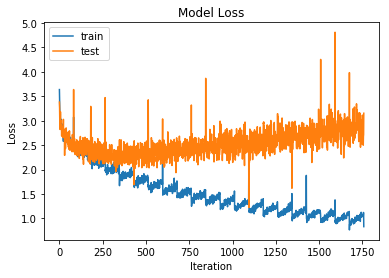

In [84]:
# summarize history for accuracy
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now we've trained our model we need some code to test it.

In [81]:
# Set up dictionary to translate indices to words
y_dictionary = dict(
            (i, char) for char, i in t_joint.word_index.items()
        )

x_dictionary = dict(
            (i, char) for char, i in t_joint.word_index.items()
        )

def seq2text(seq, dictionary):
    text = ''
    for k in seq:
        k = k.astype(int)
        # Adapted to take account of different control integers
        if k not in [t_joint.word_index["stopseq"], t_joint.word_index["startseq"], 0] and k < (len(dictionary)-1):
            w = dictionary[k]
            text = text + w + ' '
    return text

def greedy_decoder(X_seq):
    # reformat input seq
    input_seq = np.zeros((1, X_max_len))
    input_seq[0, :] = X_seq
    flag = 0
    prob = 1
    ans_partial = np.zeros((1, y_max_len))
    # Add start token integer to end of ans_partial input - initially [0,0,...BOS]
    ans_partial[0, -1] = t_joint.word_index["startseq"]  #  the index of the symbol BOS (begin of sentence)
    for k in range(y_max_len - 1):
        ye = model.predict([input_seq, ans_partial])
        yel = ye[0,:]
        p = np.max(yel)
        mp = np.argmax(ye)
        # It is this line that sets how our training data should be arranged - need to change both
        # the line below shifts the existing ans_partial by 1 to the left - [0, 0, ..., BOS, 0]
        ans_partial[0, 0:-1] = ans_partial[0, 1:]
        # This then adds the newly decoded word onto the end of ans_partial
        ans_partial[0, -1] = mp
        if mp == t_joint.word_index["stopseq"]:  #  the index of the symbol EOS (end of sentence)
            flag = 1
        if flag == 0:    
            prob = prob * p
    text = seq2text(ans_partial[0], y_dictionary)
    return(text, prob)

# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    text, prob = greedy_decoder(X_test[i])
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {} (with prob {}). \n Test title is: {} \n---".format(text, prob, Y_test_text))

Sample of claim text: 1 a method comprising determining by a media device that a smart card has been communicatively coupled to the media device communicating by the media device with the smart card through a smart card in

Predicted title is: method and apparatus for providing a mobile device mobile terminal  (with prob 4.6621154170702336e-06). 
 Test title is: module id based encryption for financial transactions  
---
Sample of claim text: 1 a processing device comprising a cpu a first interface for performing data transfer with an external terminal device in synchronization with an external clock supplied from the external terminal dev

Predicted title is: method and apparatus for power management power management power management  (with prob 0.00015047525079029634). 
 Test title is: processing device and clock control method  
---
Sample of claim text: 1 a touch controlled electronic apparatus comprising a loading plate having a display touch area a wire area and a first hot area 

#### Comments on Results

*** Possibly scrap this - there was an error in the get dataset code! ***

From this training there now appears more of a link between the claim text and the predicted title. The model seems to be learning a few patterns such as - "method and system for creating a [] method and system method". 

This result seems close:
```
Sample of claim text: 1 an apparatus comprising a capacitive sense array and a processing device wherein the capacitive sense array is configured to detect a presence of a touch object or a stylus wherein the capacitive se

Predicted title is: method and apparatus for displaying a touch screen method and apparatus for the same  (with prob 1.9565373226245597e-05). 
 Test title is: capacitive sense array for detecting touch objects and an active stylus  
 ```
 
 Training still appears unstable. Some of this may be due to the shuffling for regularisation.
 
 The results appear an improvement though on the previous model. It is worth keeping this feature.

#### Options for Further Investigation

It may be worth experimenting with different training parameters and not shuffling the data. Lowering the batch size might reduce some of the loss variance.


Also adding some regularisation may help prevent overfitting. Maybe by adding some dropout (0.2?) to the LSTMs and by adding an L2 regulariser to the dense layer.

### Chollet/Brownlee Model

This is more of a true sequence-to-sequence model, and is thus slightly more involved.

Our model consists of two portions - a portion for training and a portion for inference (i.e. for actually predicting new titles).

In [65]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

def target_one_hot(input_seqs, seq_max_len, vocab_len):
    """ Convert a sequence of integers to a one element shifted sequence of one-hot vectors."""
    one_hot_out = np.zeros((len(input_seqs), seq_max_len, vocab_len))
    for i, sequence in enumerate(input_seqs):
        for t, word_int in enumerate(sequence):
            if t > 0:
                # Shift decoder target get so it is one ahead
                one_hot_out[i, t-1, word_int] = 1
    return one_hot_out

# We need to convert this for our present problem - this is similar to our generate dataset above
# prepare data for the LSTM
def get_dataset(X, Y, i, i_end, num_decoder_tokens):
    """Return encoder_input_data, decoder_input_data, and decoder_target_data, latter as one-hot"""
    encoder_input_data = X[i:i_end]
    decoder_input_data = Y[i:i_end]
    decoder_target_data = target_one_hot(decoder_input_data, Y.shape[1], num_decoder_tokens)
    return encoder_input_data, decoder_input_data, decoder_target_data

# returns train, inference_encoder and inference_decoder models
def define_models(vocab_size, latent_dim, embedding_matrix):
    # define training encoder
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,))
    Shared_Embedding = Embedding(
        output_dim=latent_dim, 
        input_dim=vocab_size, 
        weights=[embedding_matrix]
    )
    encoder_embedding = Shared_Embedding(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    # Possibly share the embedding below
    decoder_embedding = Shared_Embedding(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    # Need to adjust this line for the embedding
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

def train_model(X_train, Y_train, X_test, Y_test, model, set_size, batch_size, num_decoder_tokens):
    """ Code to train model in sets of set_size."""
    num_examples = len(X_train)
    num_test = len(X_test)
    train_loss = []
    val_loss = []
    # Loop here to avoid memory issues with the target one hot vector
    for i in range(0, num_examples, set_size):
        if i + set_size >= num_examples:
            i_end = num_examples
        else:
            i_end = i + set_size
        # Generate a range for the test data
        i_test = math.floor(i * (num_test/num_examples))
        i_test_end = math.floor(i_end * (num_test/num_examples))
        # Generate small sets of train and test data
        I_1_train, I_2_train, Y_set_train = get_dataset(X_train, Y_train, i, i_end, num_decoder_tokens)
        I_1_test, I_2_test, Y_set_test = get_dataset(X_test, Y_test, i_test, i_test_end, num_decoder_tokens)
        print('[INFO] Training model: {}/{} samples'.format(i, num_examples))
        callback = model.fit(
            [I_1_train, I_2_train], 
            Y_set_train, 
            validation_data=([I_1_test, I_2_test], Y_set_test),
            batch_size= batch_size, 
            epochs=1
        )
        train_loss += callback.history['loss']
        val_loss += callback.history['val_loss']
    return model, train_loss, val_loss

# define model
train, infenc, infdec = define_models(vocab_size, word_embedding_size, embedding_matrix)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [66]:
train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    250000      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       embedding_2[0][0]                
__________

In [131]:
# setup variables
epochs = 10
batch_size = 64
set_size = 5000

for e in range(0, epochs):
    print("\n--------\n Epoch - ", e)
    train, tl, vl = train_model(X_train, Y_train, X_test, Y_test, train, set_size, batch_size, num_decoder_tokens)
    train_loss += tl
    val_loss += vl
    model.save_weights("chollet_weights_v2.hdf5", overwrite=True)
    


--------
 Epoch -  0
[INFO] Training model: 0/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 82s 16ms/step - loss: 1.3725 - acc: 0.7448 - val_loss: 1.7861 - val_acc: 0.7027
[INFO] Training model: 5000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 84s 17ms/step - loss: 1.3737 - acc: 0.7435 - val_loss: 1.7589 - val_acc: 0.7081
[INFO] Training model: 10000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 87s 17ms/step - loss: 1.3650 - acc: 0.7461 - val_loss: 1.7568 - val_acc: 0.7059
[INFO] Training model: 15000/20423 samples
Train on 5000 samples, validate on 1250 samples
Epoch 1/1
5000/5000 [==============================] - 87s 17ms/step - loss: 1.3451 - acc: 0.7480 - val_loss: 1.7507 - val_acc: 0.7123
[INFO] Training model: 20000/20423 samples
Train on 423 samples, validate on 10

In [135]:
# We have some data from a previous model iteration to remove
train_loss = train_loss[82:]
val_loss = val_loss[82:]

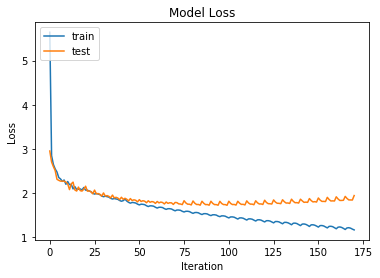

In [136]:
# summarize history for accuracy
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So here we want to stop after around 50 iterations - this is where our training and test loss diverge and marks where over-fitting begins.

We then need the inference code to allow prediction and decoding.

The general pattern is as follows:
* Predict the state with infenc using an input X vector.
* Create an initial target vector - is this 0s with first entry the startseq token 1? In the one-hot case, it's a one-hot encoding of one character - would our equivalent just be `array([1])`
* while stop condition is false, where stop condition = len=max_y_len or token=2=stopseq
    * use infdec to predict yhat and return the state of the decoder h and c 
    * remember the yhat 
    * set yhat as the next target sequence and pass generated state
    
I.e. I think we can similar code to Brownlee's or Chollet's model.

In [72]:
I_1_train, I_2_train, Y_set_train = get_dataset(X_train, Y_train, 100, 0, num_decoder_tokens)
I_1_test, I_2_test, Y_set_test = get_dataset(X_test, Y_test, 10, 0, num_decoder_tokens)

In [73]:
print(I_1_train.shape, I_2_train.shape, Y_set_train.shape)
print(I_1_test.shape, I_2_test.shape, Y_set_test.shape)

(0, 300) (0, 22) (0, 22, 2500)
(0, 300) (0, 22) (0, 22, 2500)


In [111]:
def predict_sequence(infenc, infdec, source, decoder_seq_length):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([1])
    # collect predictions
    output = list()
    for t in range(decoder_seq_length):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # update state
        state = [h, c]
        # update target sequence - this needs to be the argmax
        next_int = argmax(yhat[0, 0, :])
        output.append(next_int)
        # It seems like we throw a lot of information away here - can we build in the probabilities?
        target_seq = array([next_int])
        # Check for stopping character
        if next_int == 2:
            break
    return output

In [120]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for authenticating an identity of cardholder in financial transaction initiated by cardholder with merchant via first communication medium, said method comprising receiving purchase authenticat

Predicted title is: a more more dimensional more more more more more more more dimensional dimensional more more more more more dimensional dimensional more more . 
 Test title is: methods and systems for authenticating an identity of a in a financial transaction  
---

Sample of claim text: an array substrate including display area and peripheral area, wherein display area includes plurality of thin film transistors provided on base substrate, first transparent electrodes electrically co

Predicted title is: a more more dimensional more more more more more more more dimensional dimensional more more more more more dimensional dimensional more more . 
 Test title is: array substrate and manufacturing method thereof touch display device  
---

Sample of claim text: m

We have a lower loss than the Ludwig model but our output is the same for all predicted titles: a seemingly random set of repetitive phrases.

I have seen this form of behaviour before. One method of avoiding it was to play with the temperature of the sampling. This is explained [here](https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling) as set out below.

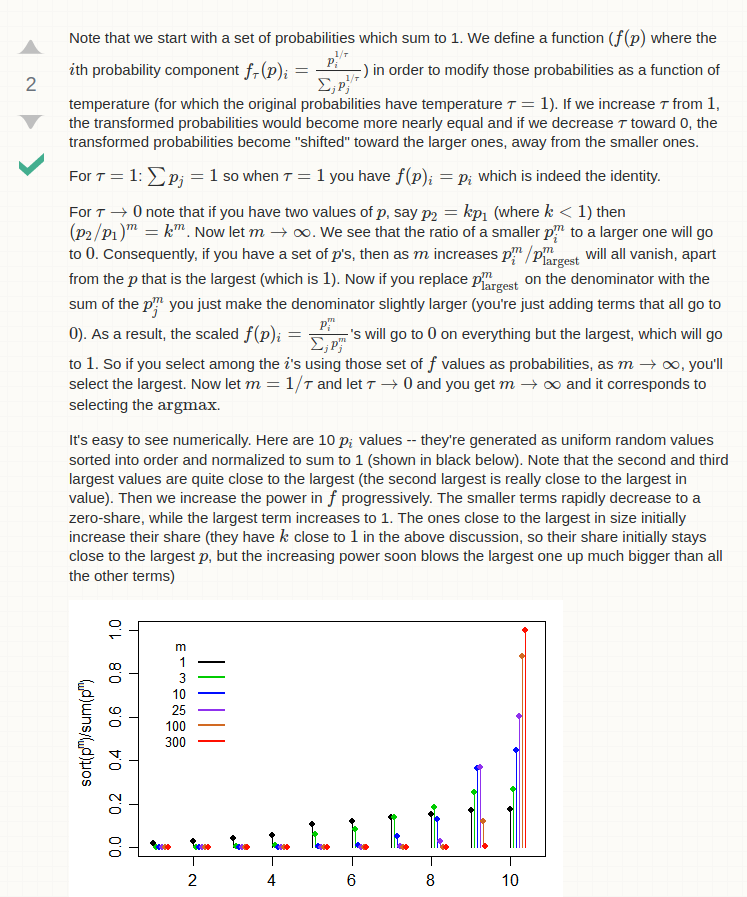

In [115]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [119]:
state = infenc.predict(X_test[1])
# start of sequence input
target_seq = array([1])
# collect predictions
output = list()
for t in range(decoder_seq_length):
    # predict next char
    yhat, h, c = infdec.predict([target_seq] + state)
    # update state
    state = [h, c]
    # update target sequence - this needs to be the argmax
    next_int = sample(yhat[0, 0, :])
    output.append(next_int)
    # It seems like we throw a lot of information away here - can we build in the probabilities?
    target_seq = array([next_int])
    # Check for stopping character
print(output)

[1226, 1415, 2180, 1370, 873, 1059, 18, 414, 364, 1926, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [124]:
def predict_sequence(infenc, infdec, source, decoder_seq_length, temp=1.0):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([1])
    # collect predictions
    output = list()
    for t in range(decoder_seq_length):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # update state
        state = [h, c]
        # update target sequence - this needs to be the argmax
        next_int = sample(yhat[0, 0, :], temp)
        output.append(next_int)
        # It seems like we throw a lot of information away here - can we build in the probabilities?
        target_seq = array([next_int])
        # Check for stopping character
        if next_int == 2:
            break
    return output

In [122]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: character string recognition method for recognizing character string comprising steps of imaging character string on medium to obtain image data first step in which first projection data of image data

Predicted title is: fidelity awareness screening using regions filtering said program . 
 Test title is: character string recognition method and device  
---

Sample of claim text: device for selectively modifying transmission performance of frame data having data size and preset transmission clock rate, frame data being transmitted through transmission interface toward an image

Predicted title is: dependent accessory candidate lock assignment algorithms initiated devices using manufacture . 
 Test title is: modification device and method for selectively modifying transmission performance of image frame data  
---

Sample of claim text: an apparatus for use as switch, comprising ring tag including ring element with an rfid circuit, ring tag attached to rotatable on

In [125]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 0.5)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for providing service address space, comprising providing service with service address space attached to main processor, wherein main processor is provided with main address space, wherein serv

Predicted title is: networked engine memory secured same . 
 Test title is: providing service address space for diagnostics collection  
---

Sample of claim text: an image processing device comprising filter control unit configured to on basis of an prediction mode, filter processing turned on or off as to neighboring pixels that are located to current block fo

Predicted title is: determination virtual rfid swap manufacturing thin session mapping advanced wireless asset sequences telematics . 
 Test title is: image processing device and method  
---

Sample of claim text: processor implemented method for operating client computing device to allow user to interact with network sites over network interface, method comprising initiating via processor operation of bro

In [126]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 0.1)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: method for using persistent party for comprising via computing device, global array according to hierarchical server architecture, wherein hierarchical server architecture enables user to create and h

Predicted title is: a volatile dimensional dimensional more more more more more more more dimensional determine dimensional more more more dimensional dimensional more more more . 
 Test title is: persistent party  
---

Sample of claim text: an input device comprising selecting section for selecting pair from among plurality of x electrodes and y electrodes disposed as being spaced apart from each other detecting section for detecting tou

Predicted title is: a volatile dimensional more more more dimensional more more more more more dimensional dimensional dimensional more more more more dimensional dimensional more . 
 Test title is: input device input control method program and electronic apparatus  
---

Sample of claim text: an image processing apparatus compri

So low temperature reproduces the default results.

In [127]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length, 1.5)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {}. \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: computer-implemented method for analyzing data representative of media material having layout, comprising identifying block segments associated with body text in media material and determining which o

Predicted title is: electrode localization funds link being . 
 Test title is: methods and systems for analyzing data in media material having layout  
---

Sample of claim text: computer interface system comprising at least one camera operable to create an image of by user, comprising plurality of features and b processing module operable to receive created image of and deter

Predicted title is: unstructured log entity plural adapted performed . 
 Test title is: for camera calibration and as a gesture based 3d interface device  
---

Sample of claim text: computer-implemented method, comprising receiving, by computing system, multiple portions of text that were input into different types of fields associated with resource selecting i first threshold va

Predicted 

In [138]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 5):
    pred_seq = predict_sequence(infenc, infdec, X_test[i], decoder_seq_length)
    predicted_text = seq2text(pred_seq, y_dictionary)
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n".format(claim_text[0:200]))
    print("Predicted title is: {} \n Test title is: {} \n---\n".format(predicted_text, Y_test_text))

Sample of claim text: an id document comprising document core layer having two opposed surfaces and on at least one surface of document core layer, comprising top layer middle layer and bottom layer, wherein point of botto

Predicted title is: removal human partitioning related recording platforms  
 Test title is: id documents having a multi layered structure  
---

Sample of claim text: method for presenting story content relating to and location of interest, method comprising receiving query comprising an intersection criteria, intersection criteria comprising location and of intere

Predicted title is: item many step chips overlay transmitting  
 Test title is: systems and methods for collaborative in a virtual space  
---

Sample of claim text: method of forming an image using plurality of comprising receiving at least one raster of image pixels each having discrete value for each of for raster associated with defective modifying values of p

Predicted title is: held appearance ex

#### Comments on Results


#### Options for Further Investigation



## Summary

In this post we have:
* Constructed two sequence-to-sequence models.
* Applied theses models to our patent claim and title data.
* Looked at the performance of each model, including identifying strengths and weaknesses.